We define classes for the problem.

In [1]:
from typing import List
import numpy as np

class Car:
    def __init__(self,car_id: int, time_slots_at_charging_unit: List[int], required_energy: int)-> None :
        self.car_id = car_id
        self.time_slots_at_charging_unit = time_slots_at_charging_unit
        self.required_energy = required_energy

    def __str__(self) -> str:
        return f"Car {self.car_id}: \n" \
               f" at charging station at time slots {self.time_slots_at_charging_unit} \n "\
               f" requires {self.required_energy} energy units"
    

class ChargingUnit:
    def __init__(self, unit_name: str, num_charging_levels: int, num_time_slots: int) -> None:
        self.unit_name = unit_name
        self.num_charging_levels = num_charging_levels
        self.num_time_slots = num_time_slots
        
        self.cars_to_charge = []

    def __str__(self) -> str:
        info_cars_registered = ""
        for car in self.cars_to_charge:
            info_cars_registered = info_cars_registered + " " + car.car_id
        return "Charging unit with\n" \
            " charging levels: " \
            f"{list(range(self.num_charging_levels))[1:-1]}\n" \
            " time slots: " \
            f"{list(range(self.num_time_slots))[1:-1]}\n" \
            " cars to charge:" \
            + info_cars_registered
    
    def register_car_for_charging(self, car: Car) -> None:
        if max(car.time_slots_at_charging_unit) > self.num_time_slots - 1:
            raise ValueError("From car required time slots not compatible "
            " with charging unit.")
        self.cars_to_charge.append(car)

    def reset_cars_for_charging(self)->None:
        self.cars_to_charge = []

    def generate_constraint_matrix(self) -> np.ndarray:
        "when a car is at a charging station the matrix element is 1 otherwise 0"
        number_cars_to_charge = len(self.cars_to_charge)
        constraint_matrix = np.zeros((number_cars_to_charge, number_cars_to_charge*self.num_time_slots))
        for row_index in range(0, len(self.cars_to_charge)):
            offset = row_index*self.num_time_slots
            cols = np.array(
            self.cars_to_charge[row_index].time_slots_at_charging_unit) # here the cars_to_charge is a list with elements of cars, those have this attribute
            constraint_matrix[row_index, offset+cols] = 1
        return constraint_matrix
    
    def generate_constraint_rhs(self) -> np.ndarray:
        """Vector with required energy as entries"""
        number_cars_to_charge = len(self.cars_to_charge)
        constraint_rhs = np.zeros((number_cars_to_charge, 1))
        for row_index in range(0, number_cars_to_charge):
            constraint_rhs[row_index] = self.cars_to_charge[row_index].required_energy # here the cars_to_charge is a list with elements of cars, those have this attribute
        return constraint_rhs
    
    def generate_cost_matrix(self) -> np.ndarray:
        number_cars_to_charge = len(self.cars_to_charge)
        return np.kron(
        np.ones((number_cars_to_charge, 1)) \
        @ np.ones((1, number_cars_to_charge)),
        np.eye(self.num_time_slots))

Creating car instances as follows

In [2]:
car_green = Car(car_id="car_green", time_slots_at_charging_unit=[0,1,2,3], required_energy=8)
car_red = Car(car_id="car_red", time_slots_at_charging_unit=[0,1,2,3,4,5,6], required_energy=12)

In [3]:
car_green.required_energy

8

In [4]:
print(car_green,'\n',car_red)

Car car_green: 
 at charging station at time slots [0, 1, 2, 3] 
  requires 8 energy units 
 Car car_red: 
 at charging station at time slots [0, 1, 2, 3, 4, 5, 6] 
  requires 12 energy units


Testing the ChargingUnit class

In [5]:
charging_unit = ChargingUnit(unit_name="charging_unit", num_charging_levels=6, num_time_slots=7)
print(charging_unit)

Charging unit with
 charging levels: [1, 2, 3, 4]
 time slots: [1, 2, 3, 4, 5]
 cars to charge:


Now let's combine the two: register cars for charging

In [6]:
charging_unit.register_car_for_charging(car_green)
charging_unit.register_car_for_charging(car_red)

print(charging_unit)

Charging unit with
 charging levels: [1, 2, 3, 4]
 time slots: [1, 2, 3, 4, 5]
 cars to charge: car_green car_red


In [7]:
cost_matrix = charging_unit.generate_cost_matrix()
print(cost_matrix)
cost_matrix.shape

[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]


(14, 14)

In [8]:
constraint_matrix = charging_unit.generate_constraint_matrix()
e = charging_unit.generate_constraint_rhs()
print("cosntraint mx: ", constraint_matrix)
print("e:",e)


cosntraint mx:  [[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
e: [[ 8.]
 [12.]]


In the following we will use Qiskit for describing the quadratic constrained integer optimization (QCIO).

In [9]:
from qiskit_optimization import QuadraticProgram


def generate_qcio(charging_unit: ChargingUnit, name: str=None) -> QuadraticProgram:
    if name is None:
        name = ""
    qcio = QuadraticProgram(name)
    for car in charging_unit.cars_to_charge:
        qcio.integer_var_list(
            keys=[f"{car.car_id}_t{t}" for t in range(0, charging_unit.num_time_slots)],
            lowerbound=0,
            upperbound=charging_unit.num_charging_levels-1,
            name="p_")
    
    constraint_matrix = charging_unit.generate_constraint_matrix()
    constraint_rhs = charging_unit.generate_constraint_rhs()

    for row_index in range(0, constraint_matrix.shape[0]):
        qcio.linear_constraint(
                linear=constraint_matrix[row_index, :],
                rhs=constraint_rhs[row_index][0],
                sense="==",
                name=f"charge_correct_energy_for_{charging_unit.cars_to_charge[row_index].car_id}")
    cost_matrix = charging_unit.generate_cost_matrix()
    qcio.minimize(quadratic=cost_matrix)
    return qcio

Creating  a QCIO class with our previously defined problem using the charging_unit with the green and red cars.

In [10]:
qcio = generate_qcio(charging_unit, name="QCIO")
print(qcio.prettyprint())

Problem name: QCIO

Minimize
  p_car_green_t0^2 + 2*p_car_green_t0*p_car_red_t0 + p_car_green_t1^2
  + 2*p_car_green_t1*p_car_red_t1 + p_car_green_t2^2
  + 2*p_car_green_t2*p_car_red_t2 + p_car_green_t3^2
  + 2*p_car_green_t3*p_car_red_t3 + p_car_green_t4^2
  + 2*p_car_green_t4*p_car_red_t4 + p_car_green_t5^2
  + 2*p_car_green_t5*p_car_red_t5 + p_car_green_t6^2
  + 2*p_car_green_t6*p_car_red_t6 + p_car_red_t0^2 + p_car_red_t1^2
  + p_car_red_t2^2 + p_car_red_t3^2 + p_car_red_t4^2 + p_car_red_t5^2
  + p_car_red_t6^2

Subject to
  Linear constraints (2)
    p_car_green_t0 + p_car_green_t1 + p_car_green_t2 + p_car_green_t3
    == 8  'charge_correct_energy_for_car_green'
    p_car_red_t0 + p_car_red_t1 + p_car_red_t2 + p_car_red_t3 + p_car_red_t4
    + p_car_red_t5 + p_car_red_t6 == 12  'charge_correct_energy_for_car_red'

  Integer variables (14)
    0 <= p_car_green_t0 <= 5
    0 <= p_car_green_t1 <= 5
    0 <= p_car_green_t2 <= 5
    0 <= p_car_green_t3 <= 5
    0 <= p_car_green_t4 <= 5

Solving the QCIO problem with a classicar optimizer from Scikit.

In [11]:
from qiskit_optimization.algorithms import CplexOptimizer
cplex_optimizer = CplexOptimizer()
qcio_minimization_result = cplex_optimizer.solve(qcio)
print("minimum point: p_min = ", qcio_minimization_result.x)
print("minimum value: f_1(p_min) = ", qcio_minimization_result.fval)

minimum point: p_min =  [0. 3. 2. 3. 0. 0. 0. 2. 0. 1. 0. 3. 3. 3.]
minimum value: f_1(p_min) =  58.0


In [12]:
len(qcio_minimization_result.x)

14

This represents 2 vectors for car_green and car car_red and tells which car how much should charge at a given time slot out of 7.

In [13]:
print(sum(qcio_minimization_result.x[:7]) - car_green.required_energy)
print(sum(qcio_minimization_result.x[7:]) - car_red.required_energy)


0.0
0.0


In [14]:
from utils import plot_charging_schedule

fig = plot_charging_schedule(
charging_unit, qcio_minimization_result.x, marker_size=20)
fig.update_layout(width=400, height=300)
fig.show()

In the following we will turn the QCIO problem into a quadratic unconstrained integer optimzation problem (QUIO). And after that into a QUBO which is for binary optimization and a QAOA can solve.

Turning the problem into an unconstrained one is just to incorporate the constraint term into the cost function on which we have to optimize. E.g.
$f_1=f_1(p)$ cost plus $C=C(p)$ constraint into $f_2(p,\rho) = f_1(p)+\rho ||(C-C(p))||^2$. And here we're still looking for a $p$ that minimizes $f_2$ with a well chosen parameter $\rho$. When $\rho$ is large enough the solution of the QUIO is also the approx solution of the QCIO as the optimization will try to reduce the contribution of the seconf term in $f_2$.

The binary encoding is performed on the variables that we want to minimize on $b = B p $ where $b_i\in{0,1}$. This transformation leads to the following optimization QUBO problem:

$\underset{b\in\{0,1\}^{\hat{N}}}{min} f_3(b, \rho)$

Usually the dimension of the encoding vector differs from the original variable, which is due to the capacity of the binary representation. So if $p_i\in{0,1,...,5}$ then its binary there is enough 3 bits for binary representation that will encode these numbers. However, no we substituted one scalar number with a binary vector, or bitstring in this case and hence the dimensionality increased.

In the following we write a comverter class that performs the QCIO $\rightarrow$ QUBO transformations.

In [15]:
from typing import Union
from qiskit_optimization.converters import QuadraticProgramConverter, \
LinearEqualityToPenalty, IntegerToBinary

class Converter(QuadraticProgramConverter):
    def __init__(self, penalty: float=None) -> None:
        """
        penalty: penalty parameter rho for the QUIO
        """
        super().__init__()  
        self._penalty = penalty
        self.linear_equality_to_penalty_converter = LinearEqualityToPenalty(penalty)
        self.integer_to_binary_converter = IntegerToBinary()
    
    def convert(self, quadratic_program: QuadraticProgram) -> QuadraticProgram:
        return self.integer_to_binary_converter.convert(self.linear_equality_to_penalty_converter.convert(quadratic_program))
    
    def interpret(self, x: Union[np.ndarray, List[float]]) -> np.ndarray:
        return self.linear_equality_to_penalty_converter.interpret(self.integer_to_binary_converter.interpret(x))

Let's convert our example of red and green cars from QCIO to QUBO

In [16]:
converter = Converter(penalty=5.1) #below penalty = 5 the QUIO will not solve the QCIO
qubo = converter.convert(qcio)
qubo.name = "QUBO"
print(qubo.prettyprint())

Problem name: QUBO

Minimize
  6.1*p_car_green_t0@0^2 + 24.4*p_car_green_t0@0*p_car_green_t0@1
  + 24.4*p_car_green_t0@0*p_car_green_t0@2
  + 10.2*p_car_green_t0@0*p_car_green_t1@0
  + 20.4*p_car_green_t0@0*p_car_green_t1@1
  + 20.4*p_car_green_t0@0*p_car_green_t1@2
  + 10.2*p_car_green_t0@0*p_car_green_t2@0
  + 20.4*p_car_green_t0@0*p_car_green_t2@1
  + 20.4*p_car_green_t0@0*p_car_green_t2@2
  + 10.2*p_car_green_t0@0*p_car_green_t3@0
  + 20.4*p_car_green_t0@0*p_car_green_t3@1
  + 20.4*p_car_green_t0@0*p_car_green_t3@2 + 2*p_car_green_t0@0*p_car_red_t0@0
  + 4*p_car_green_t0@0*p_car_red_t0@1 + 4*p_car_green_t0@0*p_car_red_t0@2
  + 24.4*p_car_green_t0@1^2 + 48.8*p_car_green_t0@1*p_car_green_t0@2
  + 20.4*p_car_green_t0@1*p_car_green_t1@0
  + 40.8*p_car_green_t0@1*p_car_green_t1@1
  + 40.8*p_car_green_t0@1*p_car_green_t1@2
  + 20.4*p_car_green_t0@1*p_car_green_t2@0
  + 40.8*p_car_green_t0@1*p_car_green_t2@1
  + 40.8*p_car_green_t0@1*p_car_green_t2@2
  + 20.4*p_car_green_t0@1*p_car_green_

The number of variable got 3x as we went to the binart representation with 3 long bitstrings.

In [17]:
number_integer_variables = qcio.get_num_integer_vars()
print(f"Number integer variables: {number_integer_variables}")
number_binary_variables = qubo.get_num_binary_vars()
print(f"Number binary variables: {number_binary_variables}")

Number integer variables: 14
Number binary variables: 42


In [18]:
A_tilde = qubo.objective.quadratic.to_array()
print(f"Dimension: {A_tilde.shape}")

Dimension: (42, 42)


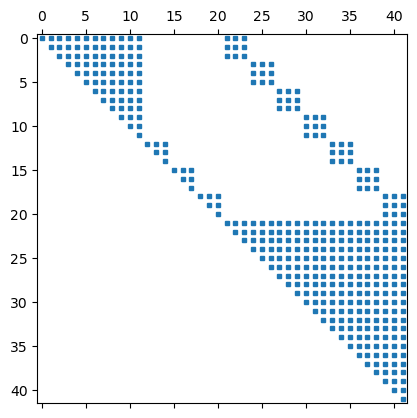

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spy(A_tilde, markersize=3)

This above matrix is $\tilde A$ that is the coefficient matrix of the quadratic term of $b$ in $f_3$.

$f_3 = b^T \tilde{A}_\rho b + L_\rho \tilde{b} +\tilde{c}_\rho$

Now we apply the previous classical solver on the same problem but now in its QUBO representation.

In [20]:
qubo_minimization_result = cplex_optimizer.solve(qubo)
print("minimum point (binary): b_min = ", qubo_minimization_result.x)
print("minimum value: f_3(b_min) = ", qubo_minimization_result.fval)

minimum point (binary): b_min =  [0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
minimum value: f_3(b_min) =  58.0


Now we got the solution $b_{min}$ in binary. We can convert it back to see if it coincides with the integer $p_{min}$.

In [21]:
b_min = qubo_minimization_result.x
p_min = converter.interpret(b_min)
print("minimum point (integer): p_min = ", p_min)
print("minimum value: f_1(p_min) = ", qcio.objective.evaluate(p_min))
print("minimum point feasible = ", qcio.is_feasible(p_min))

minimum point (integer): p_min =  [0. 3. 3. 2. 0. 0. 0. 3. 0. 0. 1. 3. 2. 3.]
minimum value: f_1(p_min) =  58.0
minimum point feasible =  True


In [22]:
fig = plot_charging_schedule(charging_unit, p_min, marker_size=20)
fig.update_layout(width=400, height=300)
fig.show()

Indeed it yields the same result.